In [3]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Basic Configuration

From the following three examples chosse one and execute only the corresponding cells.

## Galactic Areaology Example (UMi)

In [65]:
from astropy.io import ascii
import numpy as np
from collections import OrderedDict

name = "GA"

BLOCKLENGTH = 900. # block exposure time in s

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_archaeology_umi.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_sky_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_sky_mock_lowdensity.dat"  # lower density of sky objects

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )


# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used

# limit targets to a smaller field of view
#DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
DRMAX_SQ = np.inf
#DRMAX_SQ = (100./3600.)**2. # actually the whole focal plane

  
# In the case of galaxy evolution we have multiple
# fields per target.
# They should be optimize simultanously.
# In each feild we will still dither around the fiducial field
# center coordinate.

# Define dither pattern
DITHER_PATTERN = OrderedDict()
# 12 - point round dither pattern ...
a = np.deg2rad( np.arange(0., 360., 30) )
r = 100. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['{:02d}'.format(i) ] = ( x,y)

fields = OrderedDict()
fields['A'] = (228.200,   +67.500)
fields['B']  = (226.300,   +67.500)
fields['C'] = (226.000,   +66.900)
fields['D'] = (228.100,   +66.955)

# more programmatic part of the configuration, load target lists
# and comput dither positions (on sky)


pointings = OrderedDict()
for fid in fields:
    cRA,cDEC = fields[fid]
    for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
        pointing_RA, pointing_DEC = cRA + offset_ra/np.cos(np.deg2rad(cDEC)), cDEC + offset_dec
        pointings[ "P{}D{}".format(fid,did) ] = (pointing_RA, pointing_DEC) 

In [66]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the 
# cost of non-observation and non-completion 
# as a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1000000.,1e15)
cost_dict['sci_P02'] = (1000000.,1e15)
cost_dict['sci_P03'] = (1000000.,1e15)
cost_dict['sci_P04'] = (1000000.,1e15)
cost_dict['sci_P05'] = (1000000.,1e15)
cost_dict['sci_P06'] = (1000.,1e15)
cost_dict['sci_P07'] = (1000.,1e15)
cost_dict['sci_P08'] = (1000.,1e15)
cost_dict['sci_P09'] = (1000.,1e15)
cost_dict['sci_P10'] = (1000.,1e15)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf
supply_dict['sci_P02'] = inf
supply_dict['sci_P03'] = inf
supply_dict['sci_P04'] = inf
supply_dict['sci_P05'] = inf
supply_dict['sci_P06'] = inf
supply_dict['sci_P07'] = inf
supply_dict['sci_P08'] = inf
supply_dict['sci_P09'] = inf
supply_dict['sci_P10'] = inf

# needed calibration star per exposure
supply_dict['cal_P01'] = 40 # inf = try to get as many as  possible
# needed sky positions per exposure
supply_dict['sky_P01'] = 240 # inf = try to get as many as  possible


## Galaxy Evolution Example

In [186]:
from astropy.io import ascii
import numpy as np

name = "GE"

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_galaxy.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_galaxy_fcstars_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_galaxy_sky_mock.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock_lowdensity.dat"


# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


# limit targets to a smaller field of view
#DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
DRMAX_SQ = np.inf

    
#Define dither pattern
DITHER_PATTERN = OrderedDict()
# manually ...

BIN = 4
# dither in a hexagon ...
a = np.deg2rad( np.linspace(0., 360., 64/BIN) )
r = 100. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['D{:02d}'.format(i) ] = ( x,y)


BLOCKLENGTH = 900.*BIN # block exposure time in s


# more programmatic part of the configuration, load target lists
# and comput dither positions (on sky)

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# find field center and extent
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

# set (or not) fiducial field center
if [RA0, DEC0] != [np.nan, np.nan]:
    cRA, cDEC = RA0, DEC0

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 

/Users/mxhf/.pyenv/versions/3.6.0/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [187]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (10000000000.,1e15)
cost_dict['sci_P02'] = (1000000000.,1e15)
cost_dict['sci_P03'] = (100000000.,1e15)
cost_dict['sci_P04'] = (10000000.,1e15)
cost_dict['sci_P05'] = (1000000.,1e15)
cost_dict['sci_P06'] = (100000.,1e15)
cost_dict['sci_P07'] = (10000.,1e15)
cost_dict['sci_P08'] = (1000.,1e15)
cost_dict['sci_P09'] = (100.,1e15)
cost_dict['sci_P10'] = (10.,1e15)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf
supply_dict['sci_P02'] = inf
supply_dict['sci_P03'] = inf
supply_dict['sci_P04'] = inf
supply_dict['sci_P05'] = inf
supply_dict['sci_P06'] = inf
supply_dict['sci_P07'] = inf
supply_dict['sci_P08'] = inf
supply_dict['sci_P09'] = inf
supply_dict['sci_P10'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 40 # force exactly 40
# need one sky positions per exposure
supply_dict['sky_P01'] = 240 # force exactly 240


## Cosmology Example

In [48]:
from astropy.io import ascii
import numpy as np
from collections import OrderedDict

name = "COS"

BLOCKLENGTH = 900. # block exposure time in s

# Define target lists.
fscience_targets = "pfs_target_list/pfs_preliminary_target_cosmology.dat"
fcal_stars       = "pfs_target_list/pfs_preliminary_target_cosmology_fcstars.dat"
fsky_pos         = "pfs_target_list/pfs_preliminary_target_cosmology_sky.dat"


# fiducial field coortinate
RA0, DEC0 = [np.nan, np.nan] # if set to nan, central RA and DEC of targets will be used


# limit targets to a smaller field of view
DRMAX_SQ = (2700./3600.)**2. # actually the whole focal plane
#DRMAX_SQ = np.inf

# In cosmology we don't dither, there is just one visit, one fiber configuration,
# and one exposure per field.
#
# Define dither pattern
DITHER_PATTERN = {"A" : ( 0.,0.)} # No Dithers, just one fiducial position

### Only for testing performance testing against ETS
DITHER_PATTERN = OrderedDict()
# 6 - point round dither pattern ...
a = np.deg2rad( np.arange(0., 360., 60.) )
r = 10. 
xx = np.sin(a) * r/3600.
yy = np.cos(a) * r/3600.
for i,(x,y) in enumerate(zip(xx,yy)):
    DITHER_PATTERN['{:02d}'.format(i) ] = ( x,y)
### 

# more programmatic part of the configuration, load target lists
# and compute dither positions (on sky)

# Load target lists.
science_targets = ascii.read(fscience_targets)
cal_stars = ascii.read(fcal_stars)
sky_pos = ascii.read(fsky_pos)

# find field center and extent
cRA  = np.median( science_targets['RA'] )  
cDEC =  np.median( science_targets['DEC'] ) 
RAmin,RAmax   = np.min( science_targets['RA'] ), np.max( science_targets['RA'] )
DECmin,DECmax = np.min( science_targets['DEC'] ), np.max( science_targets['DEC'] )

# set (or not) fiducial field center
if [RA0, DEC0] != [np.nan, np.nan]:
    cRA, cDEC = RA0, DEC0

pointings = OrderedDict()
for did, (offset_ra, offset_dec) in DITHER_PATTERN.items():
    pointing_RA, pointing_DEC = cRA + offset_ra, cDEC + offset_dec
    pointings[did] = (pointing_RA, pointing_DEC) 

In [49]:
# Define the cost function
from numpy import inf

cost_dict = {}
# For each target class we define the cost 
# of non-observation and non-completion as 
# a two-tuple. The cost of non-completion 
# is typically larger as partial completion 
# of objects should be avoided.
cost_dict['sci_P01'] = (1e4,1e9)


# For the calibration objects we only define the cost
# of non-observation as calibration targets only *need* to be visited once.
# Note: The can of course be visited many times. But
# for the calibration objects the real constraint is to have 
# at least N out of M observed in each exposure.
# There is no requirement to revisit a specific calibration target.
cost_dict['cal_P01'] = 1e12
cost_dict['sky_P01'] = 1e12

# Here we add higher cost to later visits. Ther should be one entry per visit.
cost_dict['visits'] = OrderedDict()
for i, pid in enumerate(pointings):
      cost_dict['visits'][pid] = i*10.

# Here we discourage large cobra moves. The example here is a simple
# linear function cost = A * move_distance 
# where the parameter A controls how quickly the cost increases as funciton of distance.
#A = 250.
A = 0.
cost_dict['cobra_move'] = lambda d : d*A  


# Here we define how at least many objects out of each class we want observed.
supply_dict = {}
# By setting science object to inf, we say we want them all.
supply_dict['sci_P01'] = inf

# need one calibration star per exposure
supply_dict['cal_P01'] = 11 # force exactly 11
# need one sky positions per exposure
supply_dict['sky_P01'] = 328 # force exactly 328

## General Configuration items

In [188]:
# You can limit the problem here by constraining it to a subregion of the focal plane

# good very minimal example
#RMAX   = 10.
#CENTER = [-0.,0.]
#fieldsize   = "tinytiny"

# check for changing visibility
#RMAX   = 10.
#CENTER = [7.,-12.]
#fieldsize   = "tiny"

# intermediate example
#RMAX   = 150.
#CENTER = [0.,0.]
#fieldsize   = "intermediate"

# good small example!
#RMAX   = 25.
#CENTER = [-0.,0.]
#fieldsize   = "small"

# do them all!
RMAX   = 310.
CENTER = [-0.,0.]
fieldsize   ="all"

In [189]:
ENABLE_COLLISION_AVOIDANCE = False # enable endpoint collision avoidance, slow if there is many (>> 10k) targets
PLOT_TARGET_DISTRIBUTION   = False
PLOT_SURVEY_PLAN           = False # plot network of survey plan. Only use when restricting to very small subegions of the focal plane!
PLOT_FOCAL_PLANE           = False # plot focal plane and indicate which cobras observe what targets. 
                                   # Only use when restricting to very small subegions of the focal plane!
    
RANDOM_PRIORITIES          = False # Randomly assign priority classes to sciencetargets 
MODEL_TUNING               = False # Run model tuning

# Some necessary preparation

In [190]:
# Add current working directory to pythonpath
import sys
sys.path.append("/Users/mxhf/ownCloudRZG/work/MPE/pfs/ETS/real_test")


from matplotlib import pyplot as plt
%matplotlib inline

def pp(s):
    print(s)
    return s + "\n"

# Next two lines force automatic reload of loaded module. Convenient if
# one is still fiddeling with them.
%load_ext autoreload
%autoreload 2

# Datamodel for the flow network
import pfs_netflow.datamodel as dm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the catalogs, compute visibility ... 

In [191]:
# Convert data to lists for ETS.
import numpy as np
from numpy import hstack
from numpy import cos, deg2rad, sqrt
from numpy import unique, array
from collections import OrderedDict


ID         = hstack([science_targets['ID'],cal_stars['ID'],sky_pos['ID']])
ra         = hstack([science_targets['RA'],cal_stars['RA'],sky_pos['RA']])
dec        = hstack([science_targets['DEC'],cal_stars['DEC'],sky_pos['DEC']])
exp_times  = hstack([science_targets['EXP_TIME'],cal_stars['EXP_TIME'],sky_pos['EXP_TIME']])
priorities = hstack([science_targets['Priority'],cal_stars['Priority'],sky_pos['Priority']])

# make up target classes from target type and priority
types = ["sci"]*len(science_targets) + ["cal"]*len(cal_stars) + ["sky"]*len(sky_pos)
class_dict = {}
for id,t,p in zip(ID, types, priorities):
    class_dict[id] = '{}_P{:02d}'.format(t, p)


dra = (ra - cRA)*cos(deg2rad(cDEC))
ddec = dec - cDEC
ii = (dra**2. + ddec **2.) <= DRMAX_SQ

ID = ID[ii].tolist()
ra = ra[ii].tolist()
dec = dec[ii].tolist()
exp_times = exp_times[ii].tolist()
priorities = priorities[ii].tolist()
types = np.array(types)[ii].tolist()

c = np.array([ class_dict[t][:3] for t in ID ])
ii_sci = c == 'sci'
ii_cal = c == 'cal'
ii_sky = c == 'sky'

print( "{} science targets, {} calibration targets, and {} sky positions survive radial cut.".format(sum(ii_sci),sum(ii_cal),sum(ii_sky)))

120297 science targets, 500 calibration targets, and 1625 sky positions survive radial cut.


In [192]:
print ("Priority classes: ", np.unique(priorities))
# assign random priorities between 1 and 3 for the  science targets
if RANDOM_PRIORITIES:
    # Kohei's catalog already does come with priorities
    from numpy import random
    from numpy import array

    random.seed(42)

    N =  sum(ii_sci) 

    newpri = array( random.uniform(1.,4., size=N) , dtype=int)
    priorities = np.array(priorities)

    priorities[ii_sci] = newpri
    priorities = priorities.tolist()

Priority classes:  [1 2 3 4 5 6]


In [193]:
# compute number of required visists from exposure times
# and block length
nreqv_dict = {}
for id,t,nrv in zip(ID, types, array(exp_times)/BLOCKLENGTH):
    nreqv_dict[id] = max( int(nrv), 1)
    
print( "Unique sequence of required revisits", unique( [v for v in nreqv_dict.values()] ))

Unique sequence of required revisits [ 1  2  3  5  6 16]


In [194]:
# RANDOMISE NUMBER OF REQUIRED VISISTS
RANDOMIZENREQ = False

if RANDOMIZENREQ:
    from numpy import random
    
    NVISITS = 10
    nv = np.floor( random.uniform(NVISITS+1, size=len(ID)) ) 

    # compute number of required visists from exposure times
    # and block length
    nreqv_dict = {}
    for id,t,nrv in zip(ID, types, nv):
        nreqv_dict[id] = int(nrv)

    print( "Required revisits", unique( [v for v in nreqv_dict.values()] ))

In [195]:
import pyETS
import pycconv

# Temporary, very crude method to convert Ra/Dec pairs to x/y coordinates
# on the focal plane. To be replaced by the official functionality once
# available.
# All input angles are expected in degrees.
def radec2pos(ras, decs, raTel=None, decTel=None, posang=0.,
              time="2016-04-03T08:00:00Z"):
    if raTel is None:
        raTel = np.average(ras)
    if decTel is None:
        decTel = np.average(decs)
    return pycconv.cconv(ras,decs,raTel,decTel,posang+90.,time)

# get a data structure containing the idealized cobras
ets_cobras = pyETS.getAllCobras()

# for every pointing, compute target positions
# in the focal plane 
# and a visibilty map
visibility_maps = OrderedDict()
ets_target_pos  = OrderedDict()
for pid,(pointing_RA,pointing_DEC) in pointings.items():
    # Parse a target file and return the quantities of interest
    ets_target_pos[pid] = radec2pos(ra, dec, raTel=pointing_RA, decTel=pointing_DEC)

    # get a list of targets, and a list of Cobras that can observe them
    # keys contain object index
    # values contain indices of cobras that can observe that object.
    visibility_maps[pid] = pyETS.getVis(ets_target_pos[pid], ets_cobras)

In [196]:
#Interface to the new ETS, convert cobras, visibilities and targets to old style format
from collections import OrderedDict

# obtain cobra centers in old ETS dictionary style
cobras = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][0] ), np.imag( ets_cobras[i][0] )
        cobras["{:d}".format(i)] = [x,y]
        
# obtain dot centers in dictionary style
dots = OrderedDict()
for i,c in enumerate(ets_cobras):
        x,y = np.real( ets_cobras[i][-2] ), np.imag( ets_cobras[i][-2] )
        r = ets_cobras[i][-1]
        dots["{:d}".format(i)] = [x,y,r]


# obtain target positions in old ETS dictionary style
target_fplane_pos = OrderedDict()
for pid in ets_target_pos:
    tt = OrderedDict()
    for j,c in enumerate(ets_target_pos[pid]):
            x,y = np.real(c),np.imag(c)
            tt[ID[j]] = [float(x),float(y)]
    target_fplane_pos[pid] = tt

# obtain visibilities in old ETS dictionary style
visibilities = OrderedDict()
for pid in visibility_maps:
    vv = OrderedDict()   
    for v in visibility_maps[pid]:
        t = ID[v]
        cc = ["{:d}".format(c) for c in visibility_maps[pid][v]]
        vv[t] = cc
    visibilities[pid] = vv    

In [197]:
# This plot the focal plane, with all the target positions at all
# dither positions. Can take very long, shoudl only be done with a subset of the total 
# targets.

def filterFoV(xx,yy, maxx=20., maxy=20.):
    ii  = xx >= -maxx
    ii *= xx <=  maxx
    ii *= yy >= -maxy
    ii *= yy <=  maxy
    return ii

def my_circle_scatter(axes, x_array, y_array, radius, **kwargs):
    for x, y, r in zip(x_array, y_array, radius):
        circle = plt.Circle((x,y), radius=r, edgecolor='k', facecolor='grey', **kwargs)
        axes.add_patch(circle)
    return True

def plotFP(cobras,dots,targets,maxx=20.,maxy=20.):
    
    f = plt.figure(figsize=[10,10])
    ax = plt.subplot(1,1,1)
    
    # rearrange dot and cobra information for easy plotting
    dxx = np.array( [d[0] for did, d in dots.items()] )
    dyy = np.array( [d[1] for did, d in dots.items()] )
    drr = np.array( [d[2] for did, d in dots.items()] )
    ciddd = np.array( [did for did, d in dots.items()] )

    cxx = np.array( [c[0] for cid, c in cobras.items()] )
    cyy = np.array( [c[1] for cid, c in cobras.items()] )
    ciddd = np.array( [cid for cid, t in cobras.items()] )
    
    # plot cobras
    ii = filterFoV(cxx,cyy,maxx=maxx,maxy=maxy)
    plt.plot(cxx[ii],cyy[ii],'.', c='orange')
    ii = filterFoV(cxx,cyy )
    for x,y,l in zip(cxx[ii],cyy[ii],ciddd[ii]):
        plt.text(x,y,l)

    # plot dots
    ii = filterFoV(dxx,dyy,maxx=maxx,maxy=maxy)
    my_circle_scatter(ax, dxx[ii],dyy[ii], drr[ii] )
    

    N = len(target_fplane_pos)
    for i,pid in enumerate(target_fplane_pos):
        alpha = 1. - float(i)/float( N )

        # rearrange target information for easy plotting
        txx = np.array( [t[0] for tid, t in target_fplane_pos[pid].items()] )
        tyy = np.array( [t[1] for tid, t in target_fplane_pos[pid].items()] )
        tiddd = np.array( [tid for tid, t in target_fplane_pos[pid].items()] )

        # plot targets
        ii = filterFoV(txx,tyy,maxx=maxx,maxy=maxy)
        plt.plot(txx[ii],tyy[ii],'bo', alpha=alpha, label='pointing {}'.format(pid))

        for x,y,l in zip(txx[ii],tyy[ii],tiddd[ii]):
            plt.text(x,y,l, size=8)

        # plot visibility arcs
        if True:
            for tid,cc in visibilities[pid].items():
                tx,ty = target_fplane_pos[pid][tid]
                for c in cc:
                    cx,cy = cobras[c]
                    #print c
                    #plt.text(cx,cy,"{}".format(c) )
                    plt.plot([cx,tx],[cy,ty],'k-', alpha=alpha)


        
            
       #plt.text(zip(txx[ii],tyy[ii]),tiddd[ii], size=6)   

    plt.axis('equal')
    plt.xlim([-maxx,maxx])
    plt.ylim([-maxy,maxy])
    plt.legend()
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    
#plotFP(cobras,dots,target_fplane_pos,maxx=20.,maxy=20.)

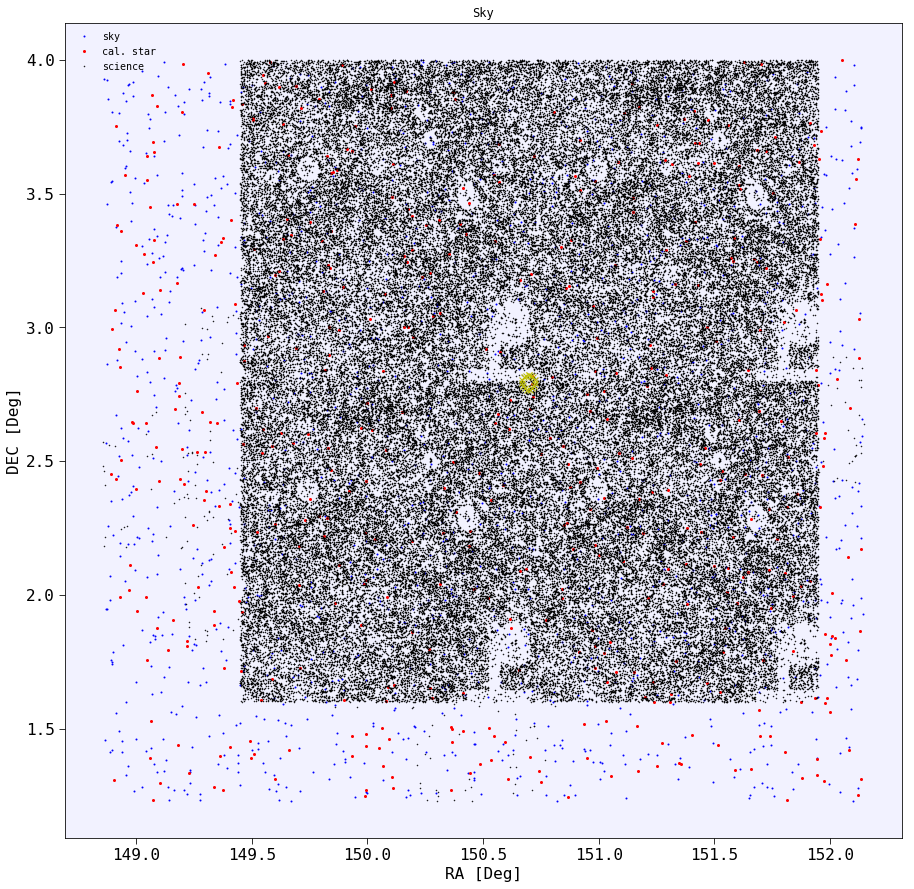

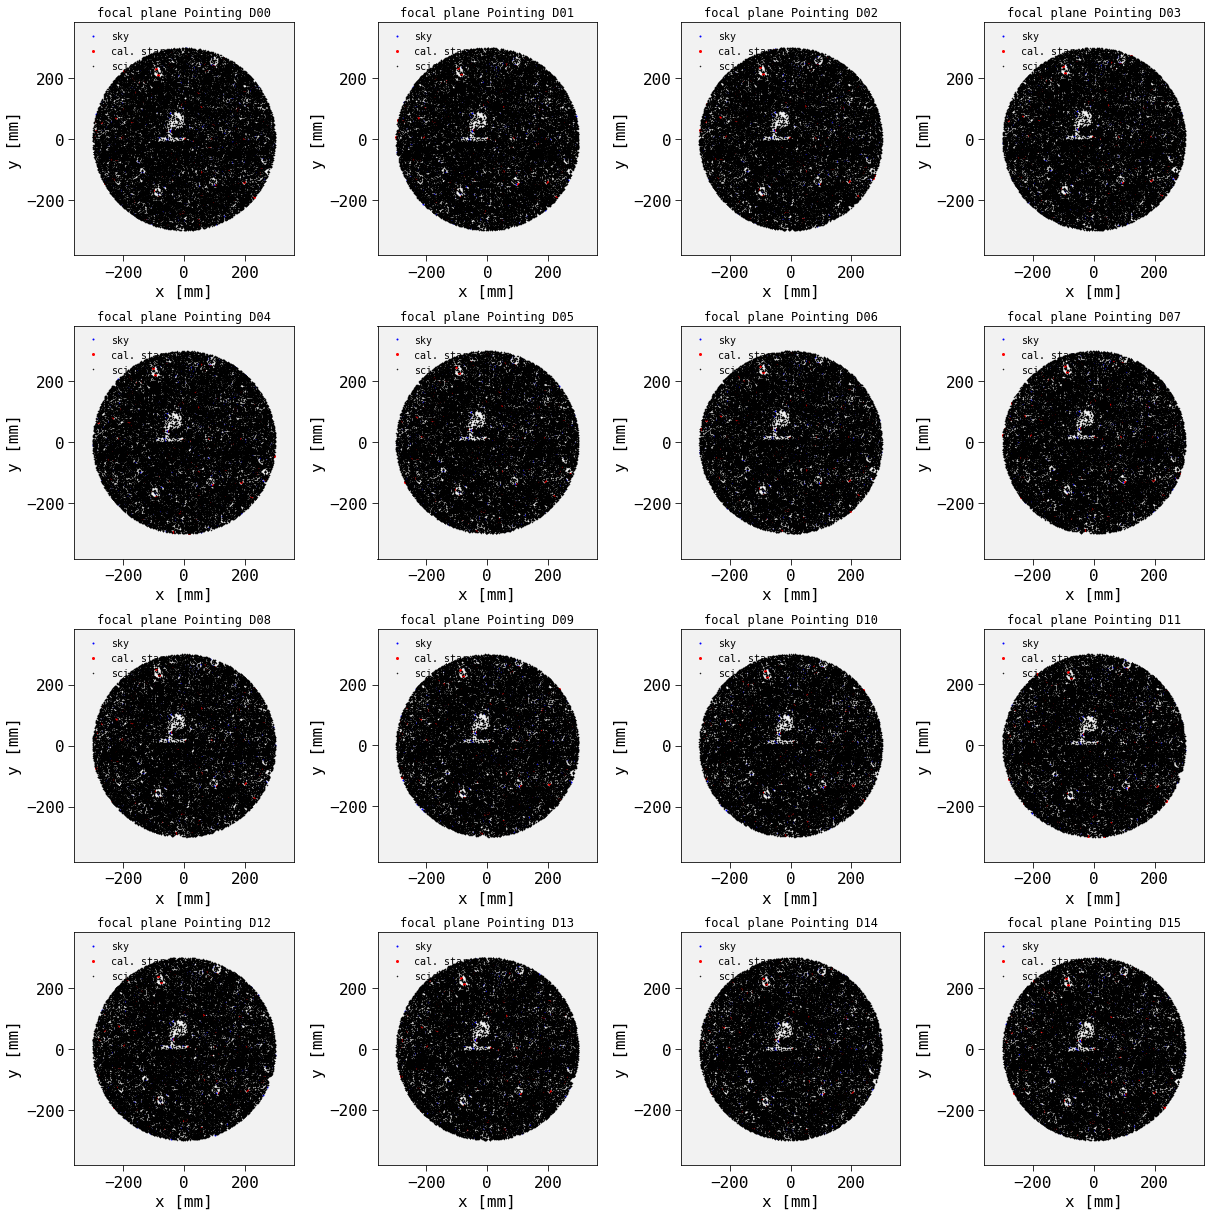

In [227]:
if PLOT_TARGET_DISTRIBUTION or True:
    from pfs_netflow.plotting import plotTargetDistribution
    plotTargetDistribution(ra, dec, types, pointings, target_fplane_pos, class_dict)

# Collisions

In [198]:
from scipy.spatial.distance import cdist

PLOT = False

# find collision pairs
fiber_collision_radius = 1.
        
# I am sure this code cound be massively optimized by subdeviding the focal plane
# also we probably don't need to do this on a per-pointing basis.
collision_pairs = OrderedDict()

if ENABLE_COLLISION_AVOIDANCE:
    for pid,(pointing_RA,pointing_DEC) in pointings.items():

        targets = target_fplane_pos[pid]
        tclasses = [class_dict[tid] for tid in target_fplane_pos[pid]]

        txx = np.array( [t[0] for tid, t in targets.items()] )
        tyy = np.array( [t[1] for tid, t in targets.items()] )

        _ii_sci = list( map( lambda x : x.startswith('sci') , tclasses ) )
        _ii_sky = list( map( lambda x : x.startswith('sky') , tclasses ) ) 
        _ii_cal = list( map( lambda x : x.startswith('cal') , tclasses ) )

        if PLOT:
            f = plt.figure(figsize=[5,5])
            plt.subplot()
            plt.plot(txx[_ii_sci],tyy[_ii_sci],'.', ms=1, label='science')
            plt.plot(txx[_ii_sky],tyy[_ii_sky],'b.' , label='sky')
            plt.plot(txx[_ii_cal],tyy[_ii_cal],'yo' , label='cal. star')


        N = len(ID)
        points = list( zip(txx,tyy) )
        Y = cdist( points[:N], points[:N] )

        # any target separation that is smaller than 2 x the collision radius will be flagged a s collision
        cc = Y <= (fiber_collision_radius*2.) 
        ncoll = int( (np.sum(cc.flatten()) - N)/2. )

        print ("Pointing {}: Found  {:d} collision pairs.".format( pid, ncoll  ))

        # identify collision pairs
        collision_pairs[pid] = []
        # array of indices
        ii = np.arange(N)
        for i in range(cc.shape[0]):
            x1,y1 =  txx[i], tyy[i]
            # only iterate over the indeces that are colliding and the upper diagonal in the collision matrix
            jj = ii[ cc[i,:] * ii > i ] 
            for j in jj: 
                if cc[i,j]:
                    x2,y2 =  txx[j], tyy[j]
                    collision_pairs[pid].append([(ID[i],x1,y1),(ID[j],x2,y2)])


        if PLOT:
            for cp in collision_pairs[pid]:
                plt.plot([cp[0][1],cp[1][1]],[cp[0][2],cp[1][2]],'r-')


            plt.axis('equal')
            l = plt.legend()
            l.draw_frame(False)
            plt.xlabel("x [mm]")
            plt.ylabel("y [mm]")
            plt.xlim([-15,15])

# Invert visibilities

In [199]:
# Compute a few statistics:
# Number of rachable targets by type and
# number of cobras that can observe any target.
def invert_vis(visibilities):
    """
    Invert visibility map, i.e. for each cobra list the observable targets
    """
    ivisibilities = OrderedDict()
    for pid in visibilities:
        cnt = 0
        ivisibilities[pid] = OrderedDict()
        for v in visibilities[pid]:
            t = v
            cc = visibilities[pid][v]

            for c in cc:
                if c in ivisibilities[pid]:
                    ivisibilities[pid][c].append(v)
                else:
                    ivisibilities[pid][c] = [v]

    return ivisibilities

ivisibilities = invert_vis(visibilities)           

In [200]:
for pid in visibilities:
    print("Pointing {}".format(pid))
    nsci_observable = 0
    ncal_observable = 0
    nsky_observable = 0

    for tid,v in visibilities[pid].items():
        if len(v) > 0:
            if class_dict[tid][:3] == 'cal':
                ncal_observable += 1
            elif class_dict[tid][:3] == 'sky':
                nsky_observable += 1
            elif class_dict[tid][:3] == 'sci':
                nsci_observable += 1
            #break


    print("{} targets positions in total.".format(sum(ii_sci) ))
    print("{} cal. targets in total.".format(sum(ii_cal) ))
    print("{} sky positions in total.".format(sum(ii_sky) ))
    print("{} cobras have at least one target in reach.".format(len(ivisibilities[pid])))
    print("{} science targets\n{} calibration targets, \
    and \n{} sky positions are in reach of at least one cobra.".format(nsci_observable, ncal_observable, nsky_observable))  
    print("")

Pointing D00
120297 targets positions in total.
500 cal. targets in total.
1625 sky positions in total.
2389 cobras have at least one target in reach.
22513 science targets
55 calibration targets,     and 
199 sky positions are in reach of at least one cobra.

Pointing D01
120297 targets positions in total.
500 cal. targets in total.
1625 sky positions in total.
2389 cobras have at least one target in reach.
22511 science targets
52 calibration targets,     and 
212 sky positions are in reach of at least one cobra.

Pointing D02
120297 targets positions in total.
500 cal. targets in total.
1625 sky positions in total.
2388 cobras have at least one target in reach.
22601 science targets
53 calibration targets,     and 
195 sky positions are in reach of at least one cobra.

Pointing D03
120297 targets positions in total.
500 cal. targets in total.
1625 sky positions in total.
2386 cobras have at least one target in reach.
22518 science targets
52 calibration targets,     and 
210 sky pos

# Execute netflow

In [201]:
# Build the survey plan graph.

from numpy import inf
from pfs_netflow.survey_plan import buildSurveyPlan
from pfs_netflow.plotting import plotSurveyPlan

print("Creating graph ...")

# for per-ponting list of targets, build
# single list of targets with multiple entries for the focal plane positions
targets = OrderedDict()
for pid in target_fplane_pos:
    tt = target_fplane_pos[pid] 
    for tid in tt:
        x,y = tt[tid]
        if not tid in targets:
             targets[tid] = OrderedDict()
        targets[tid][pid] = (x,y)
        

# build the survey plan graph
g = buildSurveyPlan(cobras, targets, nreqv_dict, visibilities, class_dict,\
                    cost_dict, supply_dict, RMAX, CENTER=(0.,0.), COBRAS=[])

print("Done.")

for pid in pointings:
    print("Pointing {}".format(pid))
    for c in g.sciTargetClasses:

        nsci = 0
        nsci_reachable = 0
        for t in g.sciTargetClasses[c].targets.values():
            if t.outarcs != []:
                nsci += 1
                nsci_reachable += 1

        print("   Number of targets in {} is {}.".format(c, nsci ) )
        print("   Number of observable targets in {} is {}.".format(c, nsci_reachable ) )


    ncal = 0
    ncal_reachable = 0
    for t in g.calTargetClasses['TClass_cal_P01_v{}'.format(pid)].targets.values():
        if t.outarcs != []:
            ncal += 1
            ncal_reachable += 1
    print("   Number of calibration stars: {}".format(ncal) )
    print("   Number of observable calibration stars: {}".format( ncal_reachable )) 


    nsky = 0
    nsky_reachable = 0
    for t in g.calTargetClasses['TClass_sky_P01_v{}'.format(pid)].targets.values():
        if t. outarcs != []:
            nsky += 1
            nsky_reachable += 1
    print("   Number of sky positions: {}".format(nsky) )
    print("   Number of observable sky positions: {}".format(nsky_reachable) )



Creating graph ...
buildSurveyPlan
Done.
Pointing D00
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 225.
   Number of observable targets in TClass_sci_P02 is 225.
   Number of targets in TClass_sci_P03 is 189.
   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7259.
   Number of observable targets in TClass_sci_P04 is 7259.
   Number of targets in TClass_sci_P05 is 44313.
   Number of observable targets in TClass_sci_P05 is 44313.
   Number of targets in TClass_sci_P06 is 5294.
   Number of observable targets in TClass_sci_P06 is 5294.
   Number of calibration stars: 55
   Number of observable calibration stars: 55
   Number of sky positions: 199
   Number of observable sky positions: 199
Pointing D01
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci

   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 225.
   Number of observable targets in TClass_sci_P02 is 225.
   Number of targets in TClass_sci_P03 is 189.
   Number of observable targets in TClass_sci_P03 is 189.
   Number of targets in TClass_sci_P04 is 7259.
   Number of observable targets in TClass_sci_P04 is 7259.
   Number of targets in TClass_sci_P05 is 44313.
   Number of observable targets in TClass_sci_P05 is 44313.
   Number of targets in TClass_sci_P06 is 5294.
   Number of observable targets in TClass_sci_P06 is 5294.
   Number of calibration stars: 56
   Number of observable calibration stars: 56
   Number of sky positions: 204
   Number of observable sky positions: 204
Pointing D12
   Number of targets in TClass_sci_P01 is 418.
   Number of observable targets in TClass_sci_P01 is 418.
   Number of targets in TClass_sci_P02 is 225.
   Number of observable targets in TClass_sci_P02 is 225.
   Number of targets in TClass

In [202]:
# now build the LP problem
from pfs_netflow.lp import buildLPProblemGRB
import time

def setflows(m, g, flows):
    flows_sol = m.getAttr('X', flows)
    for a in g.arcs.values():
        k = '{}={}'.format(a.startnode.id, a.endnode.id)
        if k in flows_sol:
            a.flow = flows_sol[k]
    
NCobras = len(g.cobras)
NSciTargets = len(g.sciTargets)
NCalTargets = len(g.calTargets)
NVISITS = len( g.visits )

summary = ""
summary += pp("NVISITS = {}".format(NVISITS))
summary += pp("Searching optimal strategy to observe in ")
summary += pp(" {} visits".format(NVISITS))
summary += pp(" {} science targets".format(NSciTargets))
summary += pp(" {} calib. targets".format(int(NCalTargets/NVISITS) ))
summary += pp(" {} cobras".format(NCobras))
summary += pp("num nodes: {}".format(len(g.nodes)))
summary += pp("num edges: {}".format(len(g.arcs)))

summary += pp("Building LP problem ...")
start_time = time.time()
model, flows, cost = buildLPProblemGRB(g, name=name)
time_to_build = time.time() - start_time
summary += pp("Time to build model: {:.4e} s".format(time_to_build))

model.write("mps/{}_{}_{}_{}.mps.gz".format(name, fieldsize, RMAX, NVISITS))

NVISITS = 16
Searching optimal strategy to observe in 
 16 visits
 57698 science targets
 642 calib. targets
 2394 cobras
num nodes: 1031875
num edges: 1554961
Building LP problem ...
Building cost equation ...
 Time to completion: 51.57 s
Time to build model: 5.2374e+01 s


In [82]:
from gurobipy import quicksum
from pfs_netflow.survey_plan import compute_collision_flow_pairs
  
if ENABLE_COLLISION_AVOIDANCE:
    flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
    print("Adding {} collision avoidance constraints.".format(len(flow_pairs)))              
    for fp in flow_pairs:
        if fp[0] in flows and fp[1] in flows:
            model.addConstr( quicksum( [ flows[ fp[0] ], flows[ fp[1] ] ] ) <= 1. )

filename = "mps/{}_{}_{}_{}.mps.gz".format(name, fieldsize, RMAX, NVISITS, rename=1)
model.write(filename)

In [211]:
model.Params.timelimit = 600000.0

Changed value of parameter timelimit to 600000.0
   Prev: 6000.0  Min: 0.0  Max: 1e+100  Default: 1e+100


In [228]:
from numpy import random

# solve it!

random.seed(42)

# Solve problem!
summary += pp("Solving LP problem ...")
start_time = time.time()

#maxSeconds=2400.
#status = solve(prob, maxSeconds=maxSeconds)
model.optimize()

time_to_solve = time.time() - start_time
summary += pp("Solve status is [{}].".format( model.status ))
summary += pp("Time to solve: {:.4e} s".format(time_to_solve))

setflows(model, g, flows)

Solving LP problem ...
Optimize a model with 1029481 rows, 1554962 columns and 3937089 nonzeros
Variable types: 1 continuous, 1554961 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+15]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [4e+01, 4e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolved: 166861 rows, 624004 columns, 1189238 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 255
  Cover: 11701
  Implied bound: 302
  Clique: 5297
  MIR: 109
  StrongCG: 19
  Flow cover: 7453
  Zero half: 166

Explored 1502 nodes (6968329 simplex iterations) in 5.38 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 6.68237e+14 1.66824e+15 1.66824e+15 ... 1.66824e+15

Optimal solution found (tolerance 1.00e-04)
Best objective 6.682366848356e+14, best bound 6.682362357149e+14, gap 0.0001%
Solve status is [2].
Time to solve: 5.413

In [229]:
from pfs_netflow.survey_plan import computeStats

stats = computeStats(g)

obj = model.getObjective()
summary += pp("{} = {}".format('Value of cost function', obj.getValue() ) )
summary += pp("[{}] out of {} science targets get observed.".format(int(stats['NSciObs']) ,NSciTargets) )
summary += pp("For {} out of these all required exposures got allocated.".format(stats['NSciComplete']))  
summary += pp("Per target class completion:")
                                                            
summary += pp("   {:15s} {:10s} {:10s} {:10s}".format('class', 'total', 'observed', 'completed') )
for tc,compl in stats['completion'].items():
    summary += pp("   {:15s} {:10d} {:10d} {:10d}".format(tc, compl['total'],compl['observed'],compl['completed']))                                                                       
    #print(tc, compl)                                                                  
summary += pp("{} targets get sent down the overflow arc.".format(stats['Noverflow']))
summary += pp("{} out of {} cobras observed a target in one or more exposures.".format(stats['Ncobras_used'], NCobras ))
summary += pp("{} cobras observed a target in all exposures.".format(stats['Ncobras_fully_used']))



Value of cost function = 668236684835610.0
[8058] out of 57698 science targets get observed.
For 8058 out of these all required exposures got allocated.
Per target class completion:
   class           total      observed   completed 
   TClass_sci_P01         418        224        224
   TClass_sci_P02         225         17         17
   TClass_sci_P03         189        131        131
   TClass_sci_P04        7259       2985       2985
   TClass_sci_P05       44313       4700       4700
   TClass_sci_P06        5294          1          1
49640 targets get sent down the overflow arc.
2394 out of 2394 cobras observed a target in one or more exposures.
2079 cobras observed a target in all exposures.


# Model tuning

In [ ]:
if MODEL_TUNING or True:
    model.tune()
    tune_results = []
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write("{}_tune_{:03d}.prm".format(name,i))

    model.getTuneResult(1)


Solving model using baseline parameter set with TimeLimit=600000s

Solving with random seed #1 ...
Optimize a model with 1029481 rows, 1554962 columns and 3937089 nonzeros
Variable types: 1 continuous, 1554961 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+15]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [4e+01, 4e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 862339 rows and 930396 columns (presolve time = 7s) ...
Presolve removed 862620 rows and 930958 columns
Presolve time: 8.97s
Presolved: 166861 rows, 624004 columns, 1189238 nonzeros
Variable types: 0 continuous, 624004 integer (596462 binary)
Found heuristic solution: objective 6.802792e+19

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Presolve removed 26400 rows and 113417 columns
Presolved: 140461 rows, 510587 columns, 992812 nonzeros

       0    1.4492503e+15   3.376875e+00   1.841222e+15     17s
  103218    6.6806616e+14   0.000000e+00   0.000000e+00     19s
  103241    6.6806616e+14   0.000000e+00   0.000000e+00     19s
Extra 23 simplex iterations after uncrush
Concurrent spin time: 0.47s

Solved with primal simplex

Root relaxation: objective 6.680662e+14, 103241 iterations, 4.19 seconds
Total elapsed time = 20.71s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6.6807e+14    0 6549 6.8028e+19 6.6807e+14   100%     -   25s
H    0     0                    1.777668e+18 6.6807e+14   100%     -   71s
H    0     0                    1.528668e+18 6.6807e+14   100%     -   72s
     0     0 6.6822e+14    0 9777 1.5287e+18 6.6822e+14   100%     -   86s
H    0     0                    3.576682e+17 6.6822e+14   100%     -  113s
     0     0 6.6823e+14    0 8563 3.5767e+17 6.6823e+14   100%     -  113s
     0

     0     0 6.6824e+14    0 5099 1.0668e+16 6.6824e+14  93.7%     -  857s
H    0     0                    5.668237e+15 6.6824e+14  88.2%     -  892s
     0     0 6.6824e+14    0 5568 5.6682e+15 6.6824e+14  88.2%     -  920s
     0     0 6.6824e+14    0 4192 5.6682e+15 6.6824e+14  88.2%     - 1042s
H    0     0                    3.668237e+15 6.6824e+14  81.8%     - 1076s
     0     0 6.6824e+14    0 4648 3.6682e+15 6.6824e+14  81.8%     - 1085s
     0     0 6.6824e+14    0 3564 3.6682e+15 6.6824e+14  81.8%     - 1204s
H    0     0                    3.668237e+15 6.6824e+14  81.8%     - 1238s
     0     0 6.6824e+14    0 4025 3.6682e+15 6.6824e+14  81.8%     - 1252s
     0     0 6.6824e+14    0 3816 3.6682e+15 6.6824e+14  81.8%     - 1374s
     0     0 6.6824e+14    0 2930 3.6682e+15 6.6824e+14  81.8%     - 1524s
H    0     0                    1.668237e+15 6.6824e+14  59.9%     - 1704s
H    0     2                    1.668237e+15 6.6824e+14  59.9%     - 1828s
     0     2 6.6824e+14  

	Aggregate 0

Solving with random seed #1 ... runtime 254.76s
Solving with random seed #2 ... runtime 459.65s
Solving with random seed #3 ... runtime 300.11s

Improvement found:
  baseline: mean runtime 3163.07s
  improved: mean runtime 338.17s
Total elapsed tuning time 34442s (60453s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 14...

	MIPFocus 1
	GomoryPasses 0

Solving with random seed #1 ... runtime 451.17s
Solving with random seed #2 ... runtime 575.21s+

Progress so far:
  baseline: mean runtime 3163.07s
  best:     mean runtime 338.17s
Total elapsed tuning time 35468s (59427s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 15...

	Method 0
	GomoryPasses 0
	Aggregate 0

Solving with random seed #1 ... runtime 419.21s
Solving with random seed #2 ... runtime 434.43s
Solving with random seed #3 ... runtime 285.49s

Progress so f

# Check up on collisions & plotting

In [ ]:
# test if really no colliding targets were observed
# This needs to be added to the survey plan and buildLPProblem methods.
#

flow_pairs = compute_collision_flow_pairs(g, collision_pairs)
 
NCOLL = 0
for fp in flow_pairs:
    
    if value( flows[ fp[0] ] ) > 0. and value( flows[ fp[1] ] ) > 0.:
        #print("{} {} in collision".format(fp[0],fp[1]))
        NCOLL += 1
                             
print("Detected {} endpoint collisions".format(NCOLL))

In [ ]:
if PLOT_SURVEY_PLAN:
    plotSurveyPlan(g)

In [ ]:
if PLOT_FOCAL_PLANE:
    from pfs_netflow.plotting import plotFocalPlane
    for pid in pointings:
        plotFocalPlane(g, pid=pid, W=30, XC=0., YC=0., name="", figsize=[5,5])


Computing target completion ...
   Pointing:  D00
   Pointing:  D01
   Pointing:  D02
   Pointing:  D03
   Pointing:  D04
   Pointing:  D05
   Pointing:  D06
   Pointing:  D07
   Pointing:  D08
   Pointing:  D09
   Pointing:  D10
   Pointing:  D11
   Pointing:  D12
   Pointing:  D13
   Pointing:  D14
   Pointing:  D15
Done, write GE_completion.txt.
 N  pid sci_P01 sci_P02 sci_P03 sci_P04 sci_P05 sci_P06 cal_P01 sky_P01
--- --- ------- ------- ------- ------- ------- ------- ------- -------
  0 D00       0       0       0       0       0       0      40     194
  1 D01       0       0       0       0       0       0      40     203
  2 D02       0       0       0       0      10       0      40     191
  3 D03       0       0       0       0      34       0      40     204
  4 D04      13       0       7       0      70       0      40     205
  5 D05      20       0      10       3     166       0      40     200
  6 D06      30       0      12      27     272       0      40     194
 

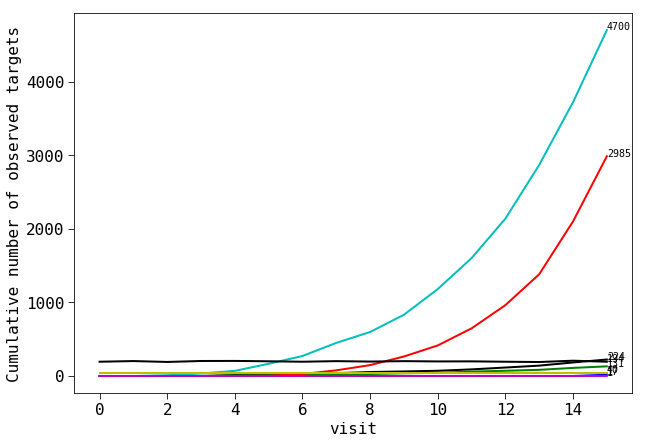

In [218]:
# more detailed per class and per pointing completion analysis
from pfs_netflow.survey_plan import computeCompletion
t = computeCompletion(g, class_dict, "{}_completion.txt".format(name))
t.pprint()

# And plot the results

f = plt.figure(figsize=[10,7])

tclasses = t.keys()[2:]

for tc in tclasses:
    plt.plot(t['N'], t[tc], label='tc', lw=2)
    plt.text(t['N'][-1], t[tc][-1], t[tc][-1])

plt.xlabel('visit')
plt.ylabel('Cumulative number of observed targets')



In [134]:
np.sum( np.array( t[['sci_P01', 'sci_P02']] ) )

TypeError: cannot perform reduce with flexible type

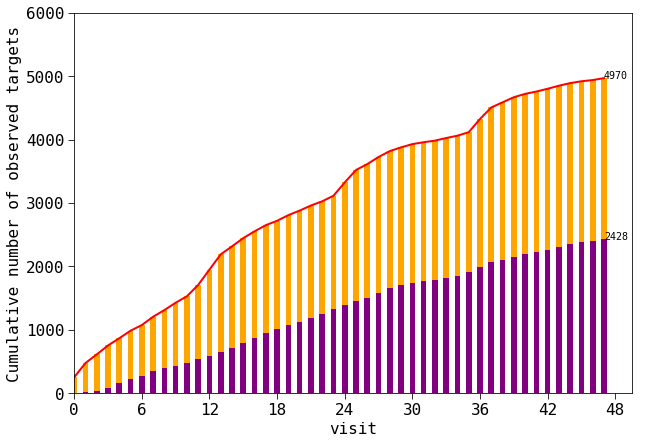

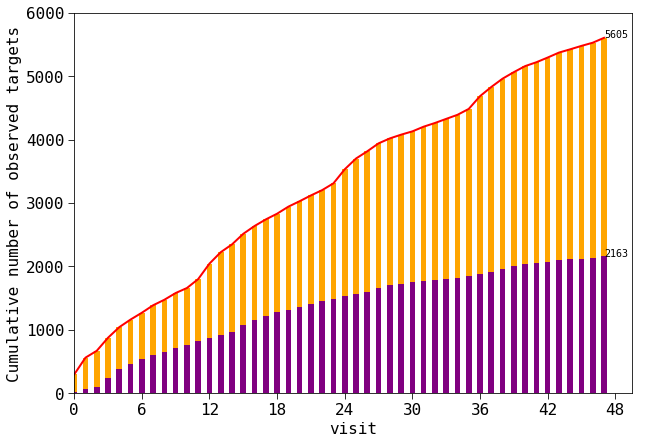

In [166]:
# And plot the results
# reproduce Hayashi san's plot for Umi

def plotKohei(_t):
    f = plt.figure(figsize=[10,7])


    P01to05 = _t['sci_P01'] + _t['sci_P02'] + _t['sci_P03'] + _t['sci_P04'] + _t['sci_P05']
    P06to10 = _t['sci_P06'] + _t['sci_P07'] + _t['sci_P08'] + _t['sci_P09'] + _t['sci_P10']
    PALL = P01to05 + P06to10
    #plt.plot(t['N'], P01to05, drawstyle='steps-mid', label='P01-P05', c='orange')
    #plt.plot(t['N'], P06to10, drawstyle='steps-mid', label='P06-P07', c='purple')

    width = 0.5

    p1 = plt.bar(_t['N'], P01to05, width, fc='purple', label='P01-P05')
    p2 = plt.bar(_t['N'], P06to10, width,
                 bottom=P01to05, fc='orange', label='P06-P07')

    plt.plot(t['N'], PALL, label='all', c='red', lw=2)


    plt.xlabel('visit')
    plt.ylabel('Cumulative number of observed targets')
    plt.text(_t['N'][-1], P01to05[-1], P01to05[-1])
    plt.text(_t['N'][-1], PALL[-1], PALL[-1])
    plt.xticks([0,6,12,18,24,30,36,42,48])

    plt.xlim([0.,49.5])
    plt.ylim([0.,6000])
    
if name == "GA":
    plotKohei(t)
    plotKohei(t_ETS)


In [ ]:
1/0

# Routine to generate random target lists

In [171]:

# make up calibration stars and sky positions
# careful IDs of all objects must be unique!!!
from astropy.table import Table, Column

cal_stars = Table()
sky_pos   = Table()

NSTAR = 400
NSKY  = int( 10000/4. * 0.65)

rr_star = np.random.uniform(size=NSTAR, low=RAmin, high=RAmax)
dd_star = np.random.uniform(size=NSTAR, low=DECmin, high=DECmax)
tt_star = np.ones_like(rr_star) * 900.
pp_star = np.ones_like(rr_star) * 1

cal_stars['ID']        = Column(["F{:06d}".format(i) for i in range(NSTAR)], unit='', description='')
cal_stars['RA']        = Column(rr_star, unit='deg', description='RA')
cal_stars['DEC']       = Column(dd_star, unit='deg', description='DEC')
cal_stars['EXP_TIME']  = Column(tt_star, unit='s', description='Exposure time')
cal_stars['Priority']  = Column(pp_star, unit='', description='Priority', dtype='int')


rr_sky = np.random.uniform(size=NSKY, low=RAmin, high=RAmax)
dd_sky = np.random.uniform(size=NSKY, low=DECmin, high=DECmax)
tt_sky = np.ones_like(rr_sky) * 900.
pp_sky = np.ones_like(rr_sky) * 1

sky_pos['ID']        = Column(["K{:06d}".format(i) for i in range(NSKY)], unit='', description='')
sky_pos['RA']        = Column(rr_sky, unit='deg', description='RA')
sky_pos['DEC']       = Column(dd_sky, unit='deg', description='DEC')
sky_pos['EXP_TIME']  = Column(tt_sky, unit='s', description='Exposure time')
sky_pos['Priority']  = Column(pp_sky, unit='', description='Priority', dtype='int')

#cal_stars.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars.dat", format="ascii", overwrite=True)
sky_pos.write("pfs_target_list/pfs_preliminary_target_archaeology_umi_fcstars_mock_lowdensity.dat", format="ascii", overwrite=True)

# prepare Cobra/Target pairs to run trajectory collision detection

In [ ]:
list(pointings.keys())[0]

In [ ]:
pid = list(pointings.keys())[0]
 
# initialize assigment list with Null
# as required by the collision simulator code.
assignments = OrderedDict()
for c in g.cobras.values():
    assignments[c.id] = 'Null'

# Now find which cobras have been assigned to which targets. 
# Loop over all targetVisit to CobraVisit arcs.Filter for those that correspond to the current visit.
for a in filter(lambda x : x.visit == visit, g.targetVisitToCobraVisitArcs.values()):
    
    if a.flow > 0.:
        t = a.startnode.target
        c = a.endnode.cobra 
        assignments[c.id] = t.id
        
for cid,tid in assignments.items():
    print("{:6s} observes {:10s}".format(cid, tid))


In [ ]:
# feed to collision code
import numpy as np
import time as time

import sys
sys.path.append("/Users/mxhf/work/MPE/pfs/src/ics_cobraOps/python")

import ics.cobraOps.plotUtils as plotUtils
import ics.cobraOps.targetUtils as targetUtils

from ics.cobraOps.Bench import Bench
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector
from ics.cobraOps.RandomTargetSelector import RandomTargetSelector

# Create the bench instanceroduct)
#bench = Bench(layout="full", calibrationProduct=calibrationP
cpos = [ [ complex(g.cobras[cid].getX(pid) , g.cobras[cid].getY(pid)) ] for cid in assignments]
bench = Bench(cobraCenters=np.array( cpos ))

print("Number of cobras:", bench.cobras.nCobras)

In [ ]:
# Calculate the total number of targets based on the bench properties
medianPatrolAreaRadius = np.median(bench.cobras.rMax)


nTargets = int(np.ceil(density * (bench.radius / medianPatrolAreaRadius) ** 2))

# Calculate the uniformly distributed target positions
ang = 2 * np.pi * np.random.random(nTargets)
radius = bench.radius * np.sqrt(np.random.random(nTargets))
targetPositions = bench.center + radius * np.exp(1j * ang)

return TargetGroup(targetPositions)

In [ ]:
# Generate the targets
targets = targetUtils.generateRandomTargets(targetDensity, bench)
print("Number of simulated targets:", targets.nTargets)

# Select the targets
selector = DistanceTargetSelector(bench, targets)
selector.run()
selectedTargets = selector.getSelectedTargets()

# Simulate an observation
start = time.time()
simulator = CollisionSimulator(bench, selectedTargets)
simulator.run()
print("Number of cobras involved in collisions:", simulator.nCollisions)
print("Number of cobras unaffected by end collisions: ", simulator.nCollisions - simulator.nEndPointCollisions)
print("Total simulation time (s):", time.time() - start)

# performance comparison ETS vs. netflow

In [102]:
len( [class_dict[ID[r]] for r in res] )

1661

In [103]:
len(ID)

12920

ALGORITHM new
# algorithm: new
# total number of vistis: 10

Ponting D00
 Number of remaining targets to observe: 122422
 Time to solve: 1.3023e-01 s
 Observed 2146 science targets, 52 calibration targets and 189 sky positions
Completed
Ponting D01
 Number of remaining targets to observe: 122422
 Time to solve: 1.2214e-01 s
 Observed 2141 science targets, 47 calibration targets and 199 sky positions
Completed
Ponting D02
 Number of remaining targets to observe: 122422
 Time to solve: 1.2013e-01 s
 Observed 2151 science targets, 51 calibration targets and 184 sky positions
Completed
Ponting D03
 Number of remaining targets to observe: 122422
 Time to solve: 1.1383e-01 s
 Observed 2140 science targets, 51 calibration targets and 193 sky positions
Completed
Ponting D04
 Number of remaining targets to observe: 122422
 Time to solve: 1.2481e-01 s
 Observed 2131 science targets, 52 calibration targets and 202 sky positions
Completed
Ponting D05
 Number of remaining targets to observe: 122422

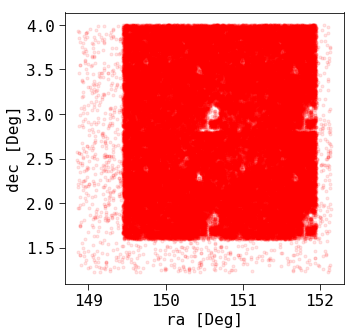

In [225]:
# Run ETS
from astropy.table import Table, Column


tclasses = [class_dict[id] for id in ID] 
uniq_tclasses = np.unique(tclasses)

def fil(xx,bb):
    """
    Takes a list of objects and a boolean list of same length.
    Retruns a list with all thos object for which the boolean
    input list had a True.
    """
    new = []
    for x,b in zip(xx,bb):
        if b: new.append(x)
    return new


import numpy as np
import time
    
ALGORITHM = "new"
ALGORITHM = "draining"
ALGORITHM = "naive"
ALGORITHM = "draining_closest"

ALL_ALGORITHM = ["new", "draining", "naive", "draining_closest"]

obs_times = np.zeros_like(ID, dtype=float) # will store how much observation time each object recieved
BLOCKTIME = 900.*4.

NVISITS = len(pointings)

for ALGORITHM in ["new"]:
    
    completed = OrderedDict() # will store cumulative list of all targets that got completed
    for tc in tclasses:
        completed[tc] = 0
    
    
    resultfile = "ets_results_{}_{}_{}_{}_{}.txt".format(name, fieldsize, RMAX, NVISITS, ALGORITHM)
    
    print("ALGORITHM {}".format(ALGORITHM))
    NVISISTS = 10
    ii_still_open = np.full_like(ID, True, dtype=bool)

    # set priorities 
    # for cosmology do 1 for claibrators, and 5 for science
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = 5
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()
    # for GA do 1 for calibrators, and original priority+2 for science, 15 will be "already observed)
    priorities2 = np.array(priorities)
    priorities2[ii_sci] = priorities2[ii_sci] + 2
    priorities2[~ii_sci] = 1
    priorities2 = priorities2.tolist()
    
    # Assemble results in a convenient table
    names = ["N", "pid"] + list(uniq_tclasses)
    
    dtype = ['i4', 'S8'] + ['i4'] * len(list(uniq_tclasses))
    t_ETS = Table(names=names, dtype=dtype)

    
    s = "# algorithm: {}\n".format(ALGORITHM)
    s += "# total number of vistis: {}\n".format(NVISISTS)

    #s += "# total number of observable science targets: {}\n".format(nsci_observable)
    #s += "# total number of observable cal. targets: {}\n".format(ncal_observable)
    #s += "# total number of observable sky positions: {}\n".format(nsky_observable)

    print(s)

    for i,pid in enumerate(pointings):
        #if i == 3:
        #    break
        # reset completion counter for stars and skys as we dont want cumulative number for those
        for tc in uniq_tclasses:
            if "cal" in tc or "sky" in tc:
                completed[tc] = 0 
    

        print("Ponting {}".format(pid))
        print(" Number of remaining targets to observe: {}".format(sum(ii)))

        #print(" Number of remaining cal. targets to observe: {}".format( sum( np.array(types)[ii] == "cal" ) ))
        #print(" Number of remaining sky targets to observe: {}".format( sum( np.array(types)[ii] == "sky" ) ))

        start_time = time.time()
        # perform target assignment using the "draining" algorithm, and return the list
        # of assigned targets and which cobras were used to observe them.
        #res = pyETS.getObs(fil(ets_target_pos,ii),fil(exp_times,ii),fil(priorities,ii),ets_cobras,"draining_closest")
        res = pyETS.getObs(ets_target_pos[pid], exp_times, priorities2, ets_cobras, ALGORITHM)
        time_to_build = time.time() - start_time
        pp(" Time to solve: {:.4e} s".format(time_to_build))

        # figure which out of all potential science targets have been observed
        # and mark them as observed (set very low priority)
        for r in res: 
            # r is the index of a particular object that was picked for observation
            if types[r] == 'sci':
                obs_times[r] = obs_times[r] + BLOCKTIME
            if obs_times[r] > 0. and obs_times[r] < exp_times[r]:
                # object recieved SOME observation but is not finished yet, 
                # set priority to the second highest (after calibration objects)
                #priorities2[r] = 2 
                pass
            elif obs_times[r] >= exp_times[r]:
                # object recieved the required observation time,
                # set to lowest priority
                tc = tclasses[r]
                if ii_still_open[r]:
                    completed[tc] = completed[tc] + 1
                    ii_still_open[r] = False # mark as done
                priorities2[r] = 15
            if types[r] == 'cal':
                tc = tclasses[r]
                completed[tc] = completed[tc] + 1
            if types[r] == 'sky':
                tc = tclasses[r]
                completed[tc] = completed[tc] + 1
       
        # compute some statistics
        nsci_observed = sum(np.array(types)[ list(res.keys()) ] == 'sci')
        ncal_observed = sum(np.array(types)[ list(res.keys()) ] == 'cal')
        nsky_observed = sum(np.array(types)[ list(res.keys()) ] == 'sky')
        
        
        print(" Observed {} science targets, {} calibration targets and {} sky positions"\
              .format(nsci_observed, ncal_observed, nsky_observed))
        print("Completed")
        #row = [i, pid, nsci_observed, ncal_observed, nsky_observed, nsci_observed_total]
        #t_ETS.add_row(row)

        row = [i, pid] + [completed[tc] for tc in uniq_tclasses]
        t_ETS.add_row(row)
        
        t_ETS.write(resultfile, overwrite=True, format="ascii.commented_header")
        
        #print(completed)
        
#np.any( np.array(types)[ res.keys() ] == 'cal' )

t_ETS.pprint()

# Plot unobserved targets
from numpy import array
from matplotlib import pyplot as plt
% matplotlib inline
f = plt.figure(figsize=[5,5])

#plt.plot(fil(ra,~ii), fil(dec,~ii), '.', color='k')
plt.plot(fil(ra,ii_still_open), fil(dec,ii_still_open), '.', color='r', alpha=0.1)

plt.ylabel('dec [Deg]')
plt.xlabel('ra [Deg]')
#plt.axis("equal")

#plt.xlim([33.25,34.74])
#plt.ylim([-5.25,-3.75])

In [216]:
t_ETS

N,pid,cal_P01,sci_P01,sci_P02,sci_P03,sci_P04,sci_P05,sci_P06,sky_P01
int32,bytes8,int32,int32,int32,int32,int32,int32,int32,int32
0,D00,52,0,0,0,0,0,0,189
1,D01,47,0,0,0,0,0,0,199
2,D02,51,0,0,0,0,201,0,184
3,D03,51,0,0,0,0,363,0,193
4,D04,52,36,0,14,0,506,0,202
5,D05,55,57,0,33,318,687,0,190
6,D06,57,82,0,47,612,903,0,190
7,D07,55,107,0,61,845,1181,1,194
8,D08,55,127,0,73,1038,1456,1,189


In [217]:
t

N,pid,sci_P01,sci_P02,sci_P03,sci_P04,sci_P05,sci_P06,cal_P01,sky_P01
int32,bytes8,int32,int32,int32,int32,int32,int32,int32,int32
0,D00,0,0,0,0,0,0,40,194
1,D01,0,0,0,0,0,0,40,203
2,D02,0,0,0,0,12,0,40,191
3,D03,0,0,0,0,41,0,40,204
4,D04,13,0,7,0,79,0,40,205
5,D05,24,0,12,7,170,0,40,200
6,D06,35,0,15,37,271,0,40,194
7,D07,45,0,25,91,456,0,40,202
8,D08,57,0,32,165,600,0,40,196


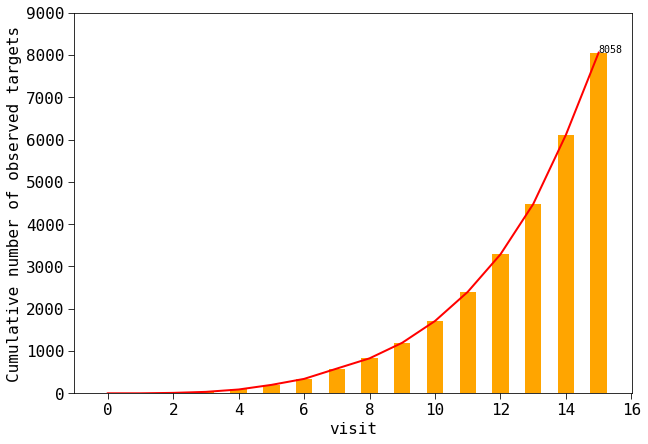

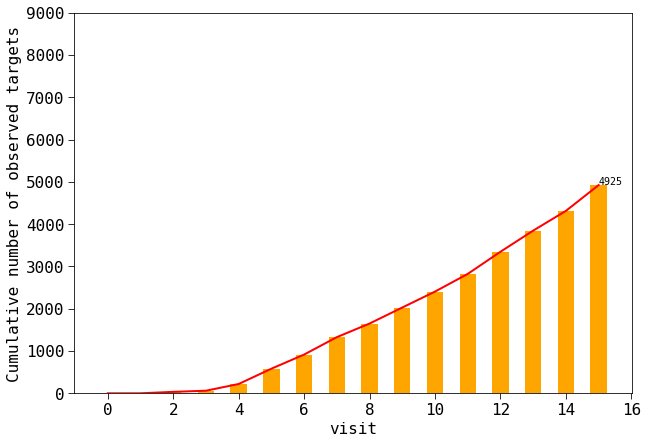

In [230]:
# And plot the results
# reproduce Hayashi san's plot for Umi

def plotGE(_t, fields = ['sci_P01', 'sci_P02', 'sci_P03', 'sci_P04', 'sci_P05', 'sci_P06']):
    f = plt.figure(figsize=[10,7])
    

    #plt.plot(t['N'], P01to05, drawstyle='steps-mid', label='P01-P05', c='orange')
    #plt.plot(t['N'], P06to10, drawstyle='steps-mid', label='P06-P07', c='purple')

    width = 0.5

    PALL = np.zeros([len(_t))
    for f in fields: 
        p1 = plt.bar(_t['N'], _t[f], width, bottom=base, label=f)
        PALL += _t[f]
                     
    #p1 = plt.bar(_t['N'], PALL, width, fc='orange', label='P01-P06')
    #p2 = plt.bar(_t['N'], P06to10, width,
    #             bottom=P01to05, fc='orange', label='P06-P07')

    plt.plot(t['N'], PALL, label='all', c='red', lw=2)


    plt.xlabel('visit')
    plt.ylabel('Cumulative number of observed targets')
    #plt.text(_t['N'][-1], P01to05[-1], P01to05[-1])
    plt.text(_t['N'][-1], PALL[-1], PALL[-1])
    #plt.xticks([0,6,12,18,24,30,36,42,48])

    #plt.xlim([0.,49.5])
    plt.legend()
    plt.ylim([0.,9000])
    
if name == "GE":
    plotGE(t)
    plotGE(t_ETS)

In [114]:
t

In [ ]:
from astropy.io import ascii

nwf_results_nvisits = {}
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
#nwf_results_nvisits[12] = ascii.read("nwf_results_nvisits12.txt")
nwf_results_nvisits[10] = ascii.read("nwf_results_nvisits10_early_obs1.txt")
#nwf_results_nvisits[9] = ascii.read("nwf_results_nvisits9.txt")
#nwf_results_nvisits[8] = ascii.read("nwf_results_nvisits8.txt")
#nwf_results_nvisits[7] = ascii.read("nwf_results_nvisits7.txt")
#nwf_results_nvisits[6] = ascii.read("nwf_results_nvisits6.txt")
#nwf_results_nvisits[5] = ascii.read("nwf_results_nvisits5.txt")
#nwf_results_nvisits[4] = ascii.read("nwf_results_nvisits4.txt")
#nwf_results_nvisits[3] = ascii.read("nwf_results_nvisits3.txt")
#nwf_results_nvisits[2] = ascii.read("nwf_results_nvisits2.txt")

ets_results = {}
ets_results["draining_closest"] = ascii.read("ets_results_draining_closest.txt")
ets_results["draining"] = ascii.read("ets_results_draining.txt")
ets_results["naive"] = ascii.read("ets_results_naive.txt")
ets_results["new"] = ascii.read("ets_results_new.txt")

#ascii.read("ets_results_draining_closest.txt",format

f = plt.figure(figsize=[8,8])

for alg in ets_results:
    plt.plot(ets_results[alg]['V']+1, ets_results[alg]['nsci_total'],'o-', label=alg)

#for nvisits in nwf_results_nvisits:
#    plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label=alg, color='grey', ms=8)

nvisits = 10
plt.plot(nwf_results_nvisits[nvisits]['V']+1, nwf_results_nvisits[nvisits]['nsci_total'],'ks-', label="netflow", color='grey', ms=8)

l = plt.legend()
l.draw_frame(False)

plt.axhline(nsci_observable,ls=":",c='k')
plt.text(1,nsci_observable+50,"max # science targets observable".format(nsci_observable),ha='left',va='bottom')
plt.ylabel("# science targets observed")
plt.xlabel("visit")
plt.ylim([500,8200])

# New & auxiliary stuff

In [ ]:
# Sanity check, make sure all flows are integer:
allflows = []
for a in g.arcs.values():
    k = '{}={}'.format(a.startnode.id,a.endnode.id)
    if k in flows:
        allflows.append(value(flows[k]))

print("All flows are integer: {}".format(all( unique(allflows)%1 == 0 )))


In [ ]:
# This is awsome rescue code. Ever found yourself deleing a call that had a 
# function implemented that you have been working on for hours?
# This is how you recover it.
if False:
    def rescue_code(function):
        import inspect
        get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

    rescue_code(buildSurveyPlan)

# Old stuff, just remaining as backup

In [ ]:
def computeStatsOld(g, flows, cost):
    stats = OrderedDict()

    NSciObs = 0
    NSciComplete = 0
    NCalObs = np.nan
    NCalComplete = np.nan
    NVISITS = len(g.visits)

    for t in g.sciTargets.values():
        NSciObs += pulp.value(sum([flows[a.id] for a in t.inarcs]))
        NSciComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
    Noverflow = 0
    for tcid, tc in g.sciTargetClasses.items():
        Noverflow += int( pulp.value(flows['{}=SINK'.format(tcid)]) )

    Ncobras_used = 0
    Ncobras_fully_used = 0
    for c in g.cobras.values():
        v = pulp.value(sum([flows[a.id] for a in c.inarcs]))
        Ncobras_used += int(v > 0)
        Ncobras_fully_used += int(v == NVISITS)
        
    stats['cost'] = pulp.value(cost)
    stats['NSciObs'] = NSciObs
    #stats['NCalObs'] = NCalObs
    stats['NSciComplete'] = NSciComplete
    #stats['NCalComplete'] = NCalComplete
    stats['Noverflow'] = Noverflow
    stats['Ncobras_used'] = Ncobras_used
    stats['Ncobras_fully_used'] =  Ncobras_fully_used
    

    compl = {}
    for stc in g.sciTargetClasses.values():
        _NObs = 0
        _NComplete = 0
        for t in stc.targets.values(): 
            _NObs += int( pulp.value(sum([flows[a.id] for a in t.inarcs])) )
            _NComplete += int(sum([pulp.value(flows[a.id]) for a in t.outarcs]) == t.gain)
            
        compl[stc.ID] = {'total' : len(stc.targets), 'observed' : _NObs, 'completed' : _NComplete}


    stats['completion'] = compl

    return stats
